# Trabajo Practico - TSA

## Introduccion

Se escoje un dataset de kaggle que contiene el indice de vegetacion de 50k puntos distintos de sudamerica.

In [1]:
#%matplotlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa as tsa
from scipy.optimize import curve_fit
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf

import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def tsplot(y, lags=None, figsize=(22, 10), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """   
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [4]:
PATH = r'C:\Users\agust\Documents'

In [5]:
DATASET = r'\Datasets\soybean_southamerica_mod13q1_evi_2000_2019.csv'

In [13]:
data = pd.read_csv(PATH+DATASET)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22850000 entries, 0 to 22849999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   fid        int64  
 1   date       object 
 2   timestamp  int64  
 3   evi        float64
dtypes: float64(1), int64(2), object(1)
memory usage: 697.3+ MB


Se toma aleatoriamente el field id 14880 para el desarrollo de este trabajo practico:

In [26]:
fid_14880 = data.where(data.fid==14880).dropna()

In [27]:
fid_14880.reset_index(drop=True, inplace=True)

In [28]:
fid_14880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fid        457 non-null    float64
 1   date       457 non-null    object 
 2   timestamp  457 non-null    float64
 3   evi        457 non-null    float64
dtypes: float64(3), object(1)
memory usage: 14.4+ KB


In [29]:
fid_14880.head()

fid        date     timestamp     evi
0  14880.0  2000-02-18  9.508320e+11  0.4750
1  14880.0  2000-03-05  9.522144e+11  0.3851
2  14880.0  2000-03-21  9.535968e+11  0.4581
3  14880.0  2000-04-06  9.549792e+11  0.3466
4  14880.0  2000-04-22  9.563616e+11  0.3867

Se quitan las columnas fid y timestamp

In [30]:
fid_14880.drop(labels=['fid', 'timestamp'], axis=1, inplace=True)

Se convierte la columna Date en tipo 'datetime'

In [31]:
fid_14880['date'] = pd.to_datetime(fid_14880['date'], format="%Y-%m-%d")

In [32]:
fid_14880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    457 non-null    datetime64[ns]
 1   evi     457 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.3 KB


In [33]:
fid_14880.head()

date     evi
0 2000-02-18  0.4750
1 2000-03-05  0.3851
2 2000-03-21  0.4581
3 2000-04-06  0.3466
4 2000-04-22  0.3867

In [34]:
fid_14880.tail()

date     evi
452 2019-10-16  0.3244
453 2019-11-01  0.3315
454 2019-11-17  0.5639
455 2019-12-03  0.5876
456 2019-12-19  0.6166

In [35]:
fid_14880.describe()

evi
count  457.000000
mean     0.408142
std      0.087391
min      0.182400
25%      0.347100
50%      0.404700
75%      0.465900
max      0.773800

## Punto 1:
* Graficar una serie a partir de un dataset relevante. Explicar observaciones.

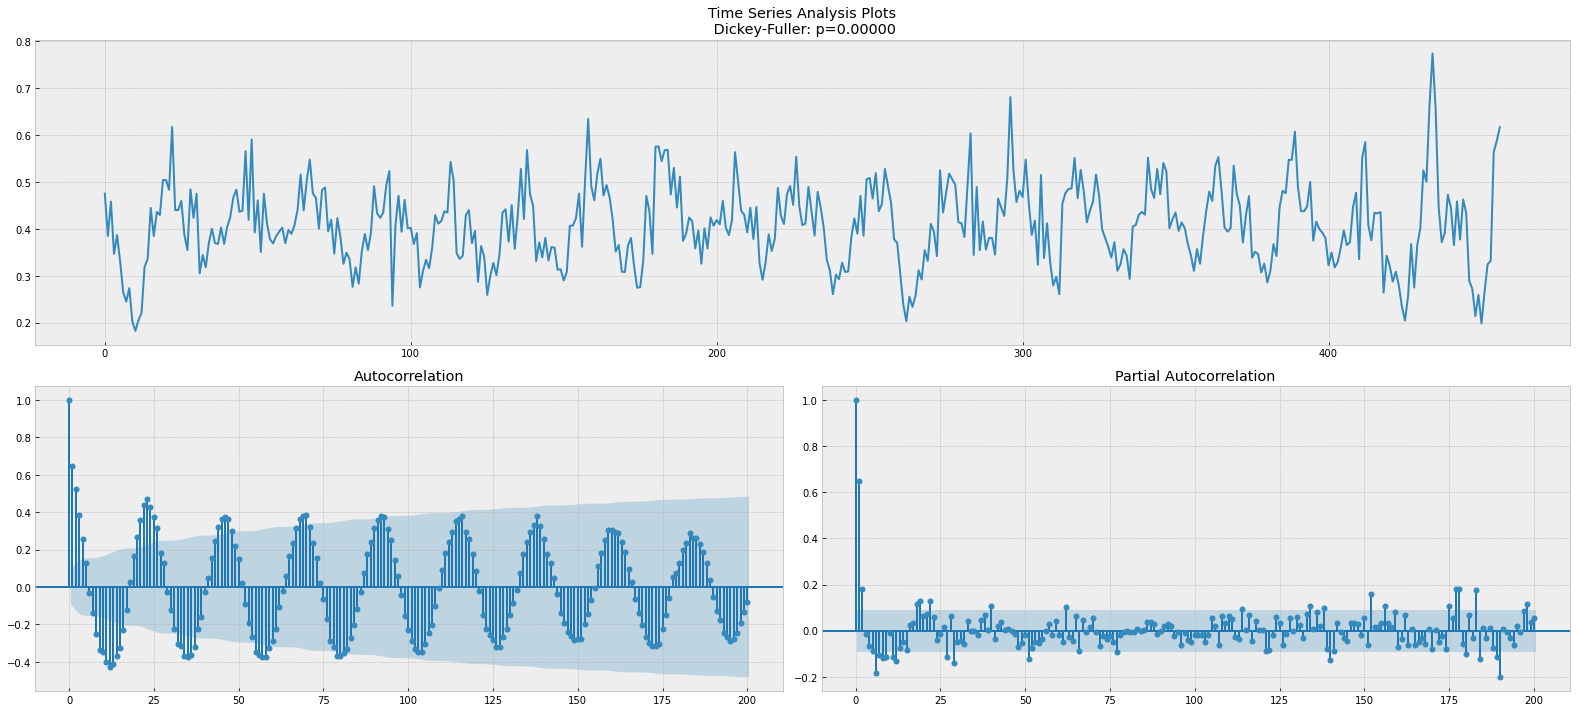

In [44]:
tsplot(fid_14880['evi'], lags=200)
plt.show()

<AxesSubplot:ylabel='Frequency'>

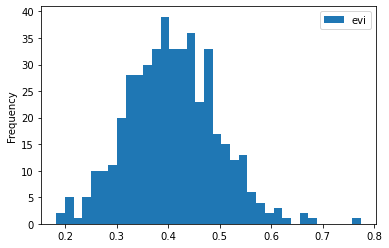

In [45]:
fid_14880.plot(x='date',y='evi', kind='hist', bins = 35)

La serie de tiempo elegida muestra la evolucion del indice de cultivo entre los periodos de febrero del 2000 y diciembre del 2019.

Se puede observar un comportamiento periodico y dada la naturaleza del dataset se puede suponer que depende de los ciclos del cultivos, con un periodo observable que pareceria ser cada 12 meses.

Se puede diferencial cada periodo a pesar de ser una señal muy ruidosa.

A partir de su autocorrelacion podemos ver que es estacionaria.

## Punto 2:
* Descomponer una serie de tiempo usando el modelo aditivo y el modelo multiplicativo.

La descompocision se realiza de tal modo que nos queden los siguientes modelos:

Modelo Aditivo:

    Y(t) = T(t) + S(t) + C(t) + e(t)

Modelo Multiplicativo:

    Y(t) = T(t) * S(t) * C(t) * e(t)

Con:

T(t): tendencia.
S(t): variación estacional.
C(t): Componente cíclico.
e(t): Componente aleatoria.

En un primer paso utilizaremos la funcion seasonal_descompose de la libreria statsmodels. Esta funcion nos devolvera ambos modelos antes descriptos, sin considerar la componente ciclica. Modelos de la funcion seasonal_descompose:
   * The additive model is Y[t] = T[t] + S[t] + e[t]
   * The multiplicative model is Y[t] = T[t] * S[t] * e[t]
   
Los parametros de esta funcion son:
   * Los valores de la serie de tiepo en cuestion
   * El tipo de modelo a calcular
   * El periodo de la serie. En este caso el periodo es 21, ya que de la visualizacion de la grafica se desprende que hay un ciclo por año.

In [46]:
fid_14880_2 = fid_14880
fid_14880_2 = fid_14880_2.set_index(pd.DatetimeIndex(fid_14880_2['date']))
fid_14880_2.sort_index(ascending=True, inplace=True)
fid_14880_2 = fid_14880_2['evi']

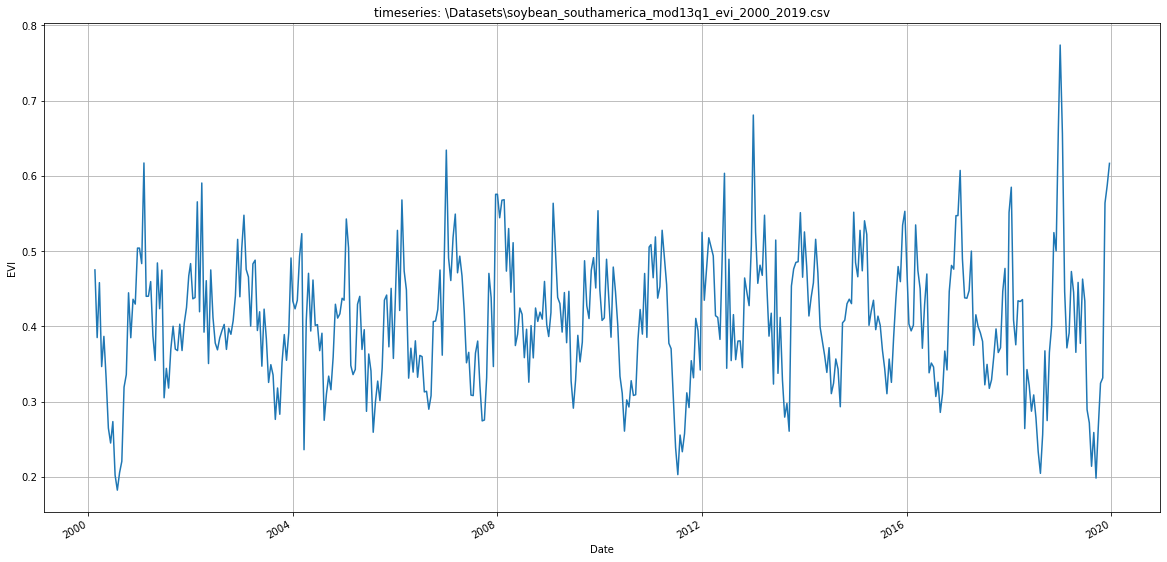

In [48]:
fid_14880_2.plot(figsize=(20,10))
plt.title("timeseries: " + DATASET)
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid()
plt.show()

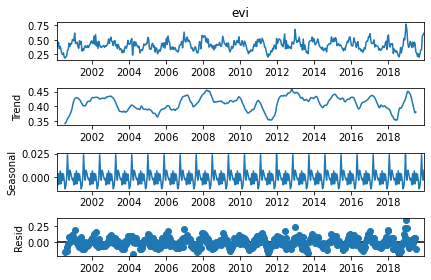

In [51]:
# Additive
addit = sm.tsa.seasonal_decompose(fid_14880_2, model='additive', period = 20)
addit.plot()
plt.show()

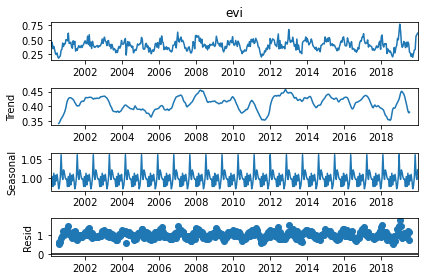

In [52]:
# Multiplicative
mult = sm.tsa.seasonal_decompose(fid_14880_2, model='multiplicative', period = 20)
mult.plot()
plt.show()

## Punto 3:
* Aplicar los modelos vistos en clase:
    - Para la tendencia usar cuadrados mínimos y expresar los coeficientes. Sacar conclusiones acerca de la validez del modelo
    - Componente cíclica: usar análisis espectral y hallar las frecuencias principales
    - Para la componente estacional usar ARIMA
    - Para la componente de error obtener R_k, C_k

##### Calculo de la tendencia como funcion cuadratica

A continuacion se estimara la tendencia como una funcion cuadtratica: 

In [53]:
def objective(t,a,b,c):
    return a*t**2+b*t+c

In [54]:
x = fid_14880.date.values

In [55]:
x = pd.to_numeric(fid_14880['date']).values

In [56]:
y = fid_14880.evi.values

In [57]:
x = (x-x.min())/(x.max()-x.min())

In [58]:
popt, _ = curve_fit(objective, x, y)
a,b,c = popt

Parametros de T(t) = a t^2 + b t + c

In [59]:
print('a:', a)
print('b:', b)
print('c:', c)

a: -0.09052178160947655
b: 0.10666080174568526
c: 0.38501384871166233


In [60]:
y_tend = objective(x,a,b,c)

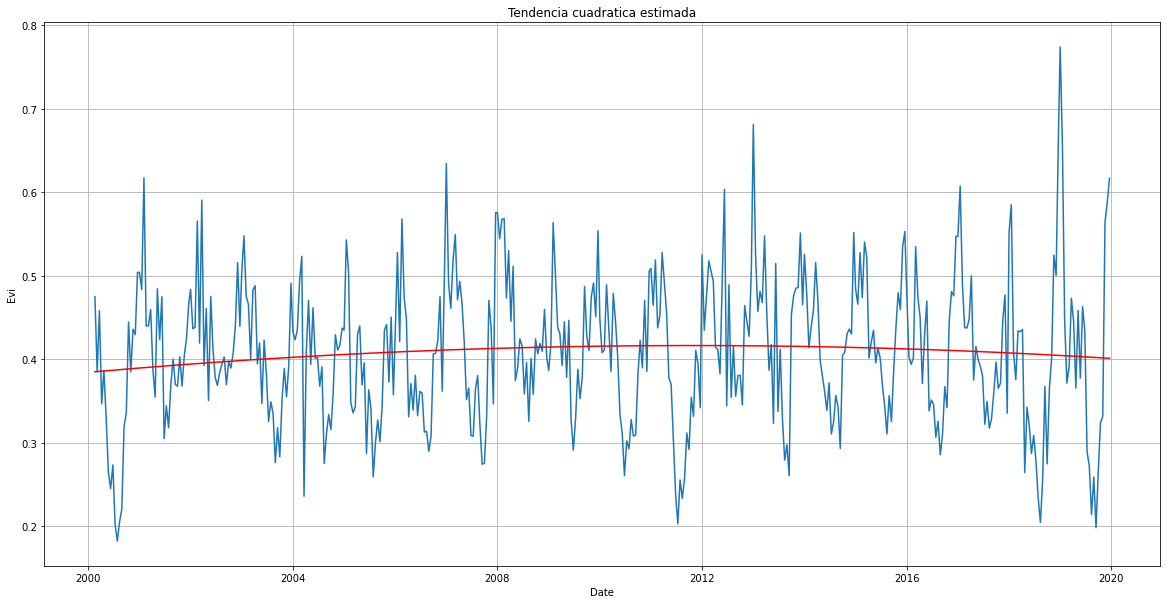

In [61]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values, y)
ax.plot(fid_14880['date'].values,y_tend, color = 'red')
ax.set_title("Tendencia cuadratica estimada")
ax.set_xlabel("Date")
ax.set_ylabel("Evi")
ax.grid(True)
plt.show()

#### Metodo de cuadrados minimos

In [64]:
Xt = y - y_tend

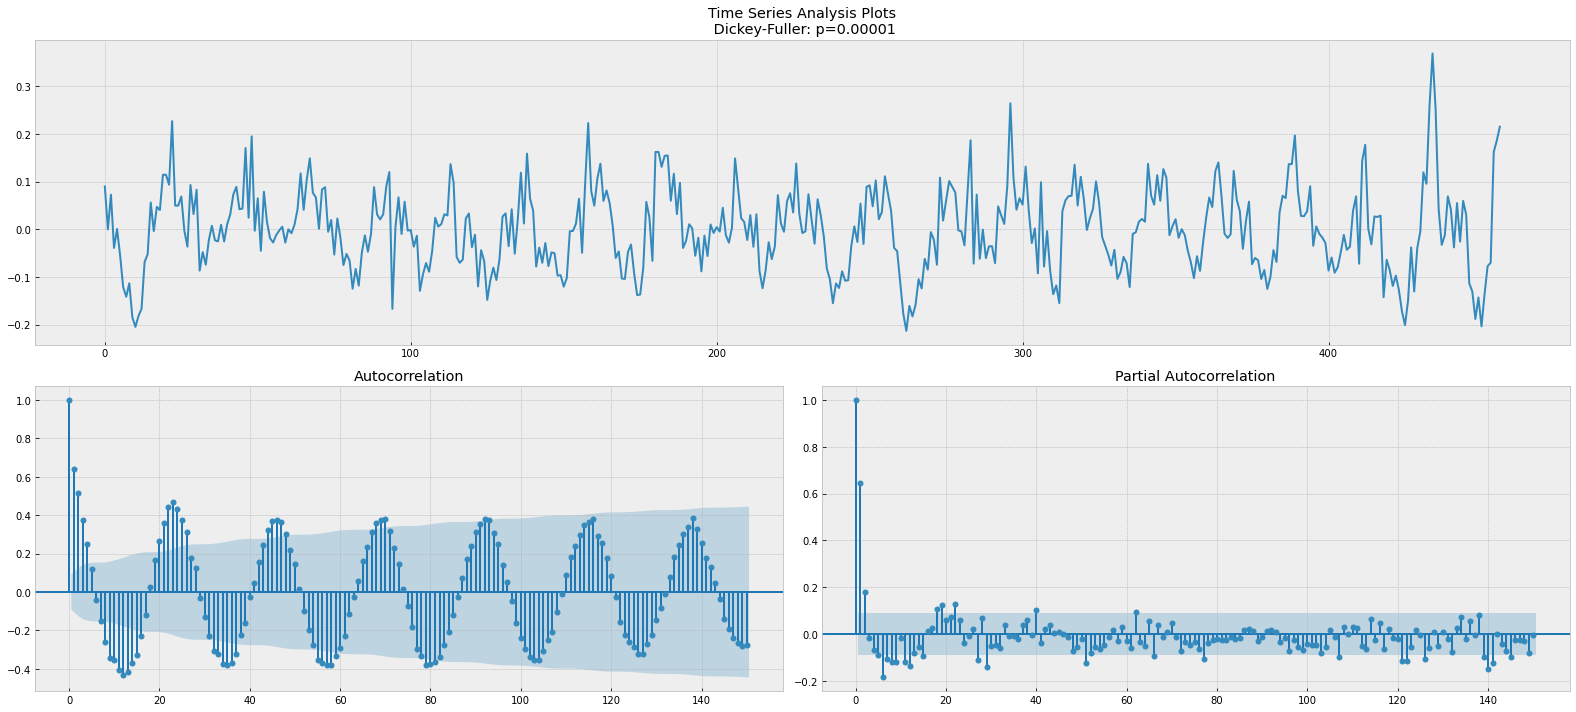

In [65]:
tsplot(Xt, lags=150)
plt.show()

In [66]:
print("Media : ",np.mean(Q))
print("Varianza : ",np.std(Q)**2)

Media :  6.582813798073354e-12
Varianza :  0.007552825395942476


#### Frecuencias principales

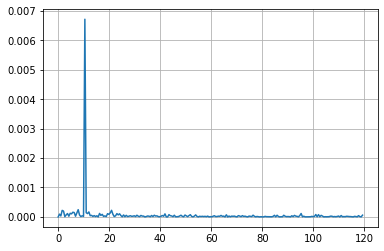

In [124]:
G, Pyy_den = signal.periodogram(y, 239)
plt.plot(G, Pyy_den)
plt.grid()
plt.show()

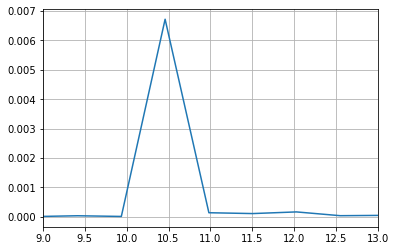

In [125]:
G, Pyy_den = signal.periodogram(y, 239)
plt.plot(G, Pyy_den)
plt.grid()
plt.xlim(9,13)
plt.show()

#### Calculo de componente ciclica

Calcularemos esta componente despejando Y(t) de los modelos:

Modelo Aditivo:

    Y(t) = T(t) + S(t) + C(t) + e(t)

Modelo Multiplicativo:

    Y(t) = T(t) * S(t) * C(t) * e(t)
    
Y(t) es dato, nuestra serie de tiempo
T(t), S(t), e(t) fueron provistos por la funcion seasonal_decompose.

Calcularemos la componente ciclica para la funcion de tendencia cuadratica y la funcion dada por seasonal_decompose.

In [79]:
# Modelo aditivo
Ct_add = addit.trend - y_tend

# Modelo multiplicativo
Ct_mult = mult.trend / y_tend

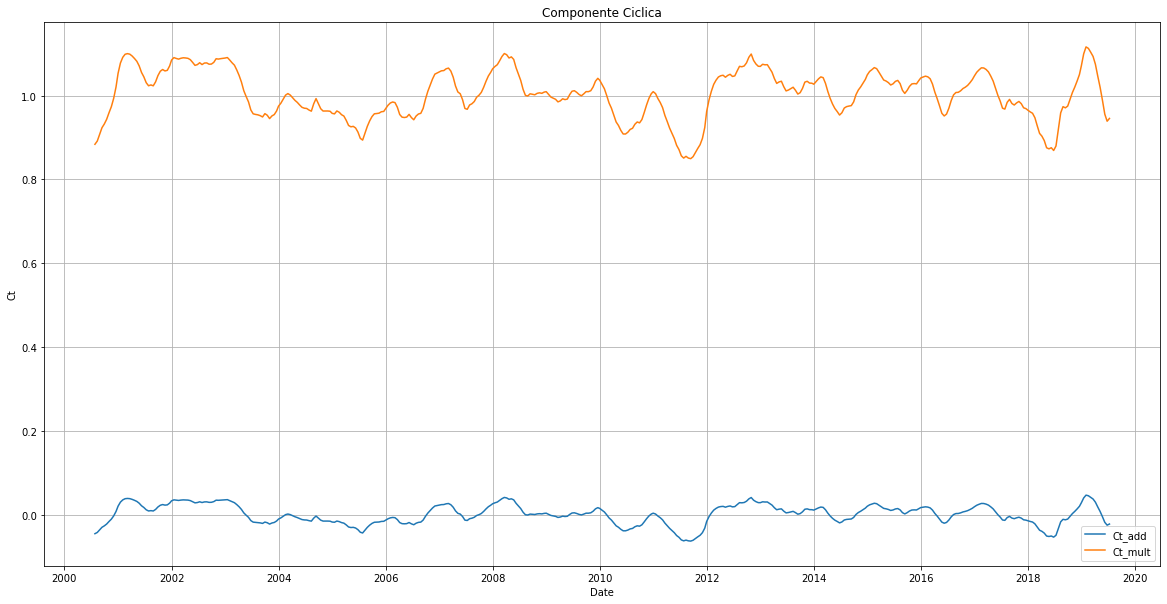

In [81]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values, Ct_add)
ax.plot(fid_14880['date'].values, Ct_mult)
ax.set_title("Componente Ciclica")
ax.set_xlabel("Date")
ax.set_ylabel("Ct")
ax.legend(['Ct_add', 'Ct_mult'])
ax.grid(True)
plt.show()

### Modelo Aditivo ARIMA

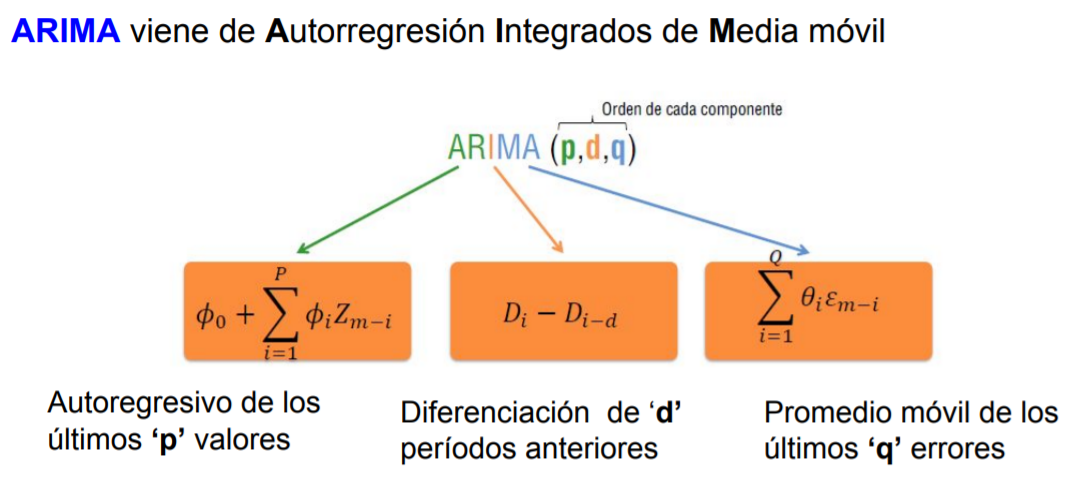

In [118]:
arima = ARIMA(fid_14880['evi'], order=(5,0,3))
arima_fit = arima.fit()
print(arima_fit.summary())

C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    evi   No. Observations:                  457
Model:                 ARIMA(5, 0, 3)   Log Likelihood                 616.385
Date:                Wed, 15 Dec 2021   AIC                          -1212.771
Time:                        21:33:49   BIC                          -1171.524
Sample:                             0   HQIC                         -1196.524
                                - 457                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4097      0.004    112.849      0.000       0.403       0.417
ar.L1          0.2328      1.399      0.166      0.868      -2.510       2.975
ar.L2          0.9318      1.264      0.737      0.4

C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


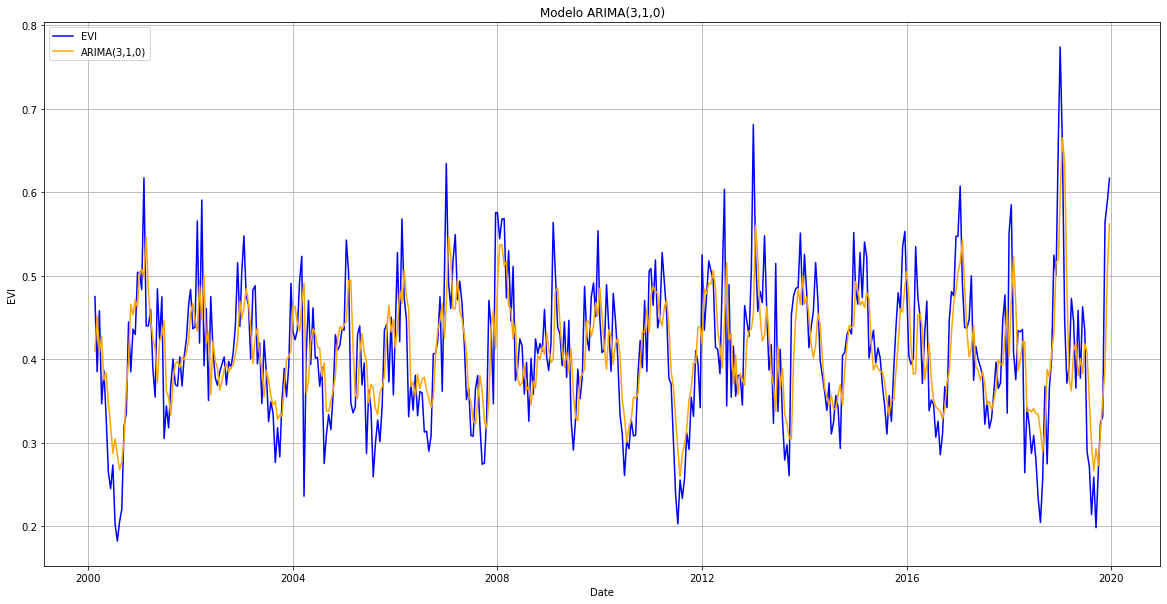

In [116]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values, fid_14880['evi'], color = 'blue')
ax.plot(fid_14880['date'].values, arima_fit.fittedvalues, color = 'orange')
ax.set_title("Modelo ARIMA(5,0,3)")
ax.set_xlabel("Date")
ax.set_ylabel("EVI")
ax.legend(['EVI', 'ARIMA(5,0,3)'])
ax.grid(True)
plt.show()

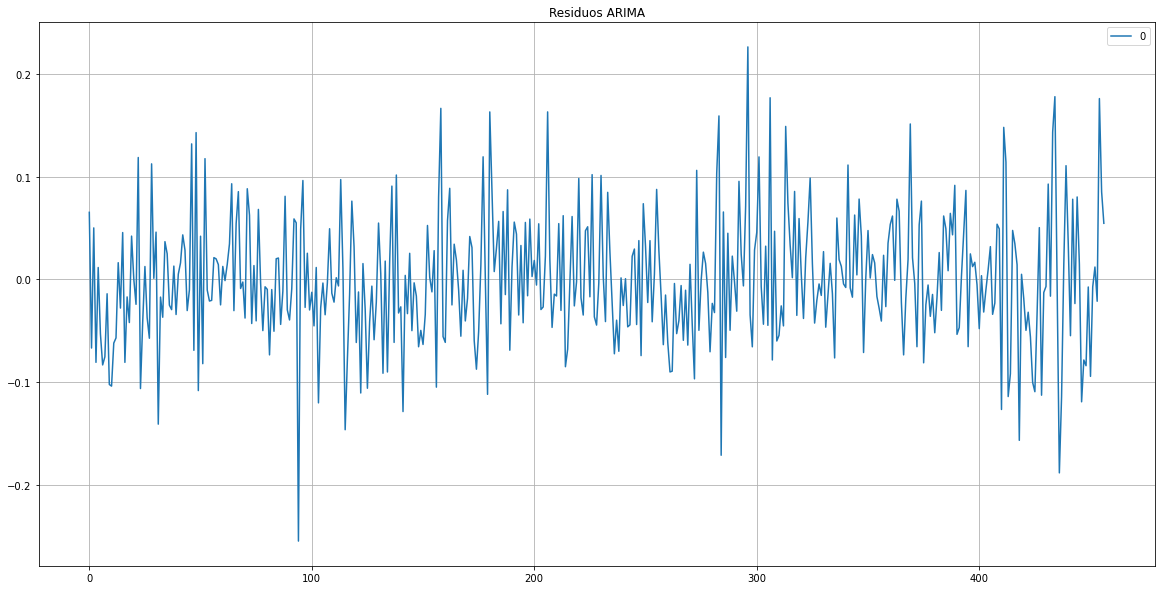

In [126]:
residuals_arima = pd.DataFrame(arima_fit.resid)
residuals_arima.plot(figsize = (20,10))
plt.title('Residuos ARIMA')
plt.grid()
plt.show()

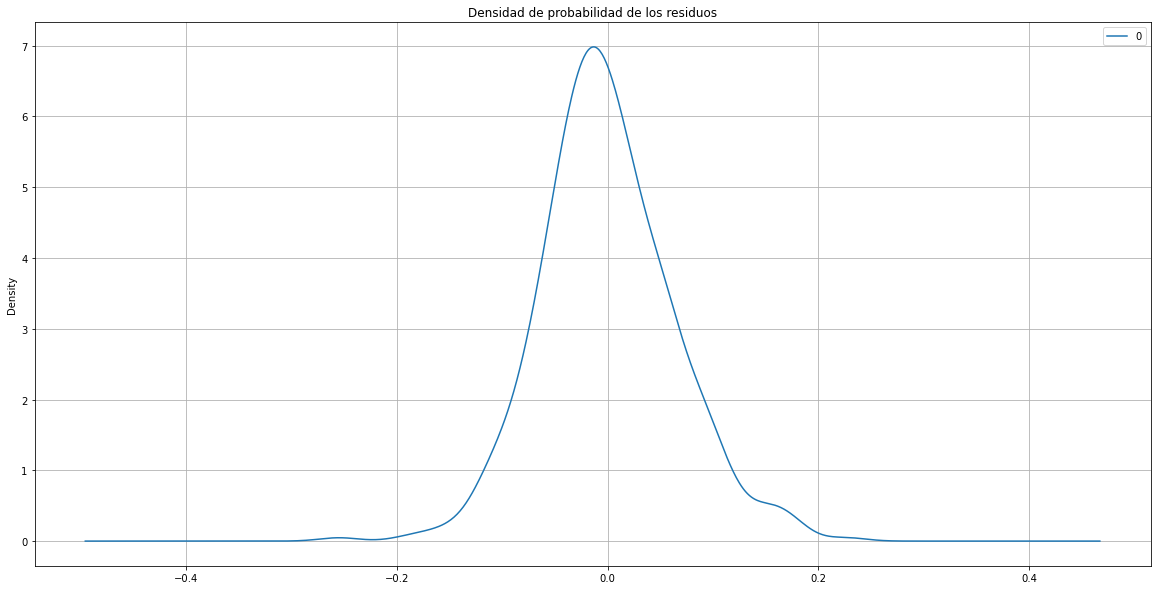

In [127]:
# density plot of residuals
residuals_arima.plot(kind='kde',figsize = (20,10))
plt.title("Densidad de probabilidad de los residuos")
plt.grid()
plt.show()

In [128]:
# summary stats of residuals
print(residuals_arima.describe())

                0
count  457.000000
mean    -0.000443
std      0.062863
min     -0.254958
25%     -0.040477
50%     -0.005501
75%      0.035293
max      0.226521


C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\tsa\stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


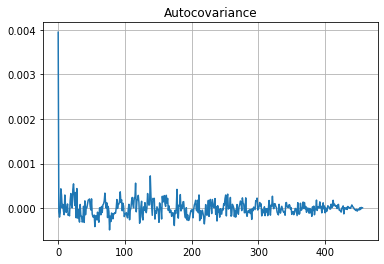

In [129]:
# Autocovarianza
#C_k del residuo
plt.plot(acovf(residuals_arima))
plt.grid(True)
plt.title("Autocovariance")
plt.show()

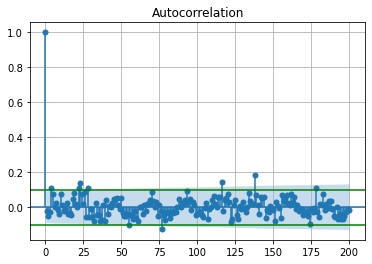

In [130]:
# Autocorrelacion
# R_k
plot_acf(residuals_arima, lags=200)
plt.grid(True)
plt.axhline(y=0.1, color='green')
plt.axhline(y=-0.1, color='green')
plt.show()

### Modelo Multiplicativo: SARIMA

SARIMA(p,d,q)x(P,D,Q)s, con período estacional s


In [142]:
SARIMA = sm.tsa.statespace.SARIMAX(fid_14880.evi.values, order=(3, 0, 1), seasonal_order=(1, 0, 1, 28)).fit(disp=-1)

In [143]:
print(SARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  457
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 28)   Log Likelihood                 575.443
Date:                            Wed, 15 Dec 2021   AIC                          -1136.886
Time:                                    21:55:50   BIC                          -1108.014
Sample:                                         0   HQIC                         -1125.514
                                            - 457                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5252      0.530      0.991      0.321      -0.513       1.563
ar.L2          0.3385      0.358   

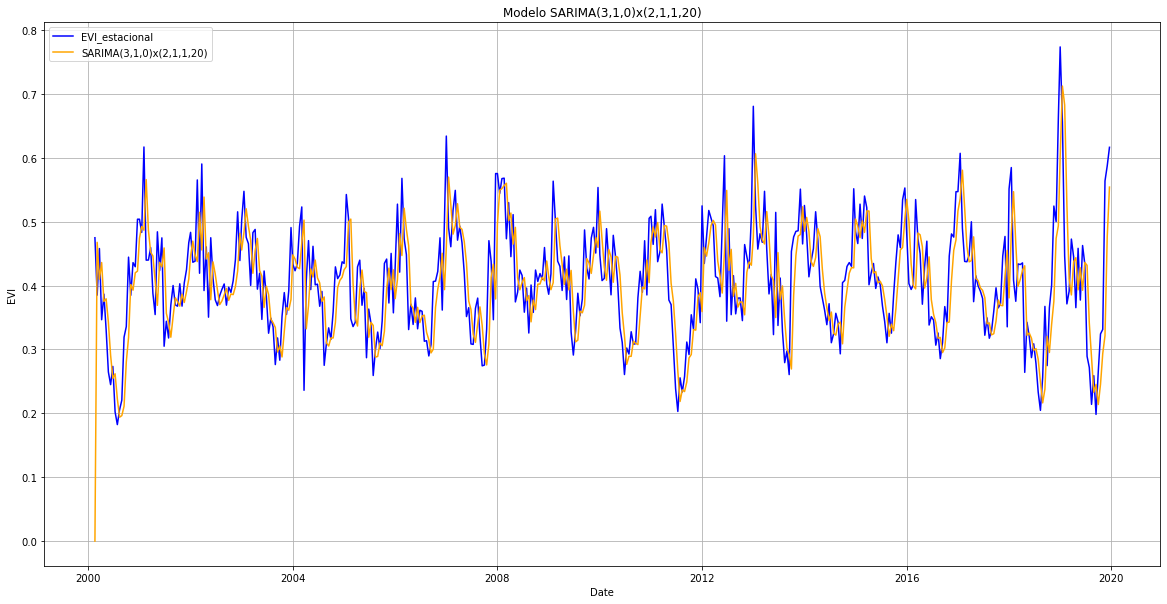

In [144]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values,fid_14880.evi.values, color = 'blue')
ax.plot(fid_14880['date'].values,SARIMA.fittedvalues, color = 'orange')
ax.set_title("Modelo SARIMA(3,0,1)x(1,0,1,28)")
ax.set_xlabel("Date")
ax.set_ylabel("EVI")
ax.legend(['EVI_estacional', 'SARIMA(3,0,1)x(1,0,1,28)'])
ax.grid(True)
plt.show()

C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


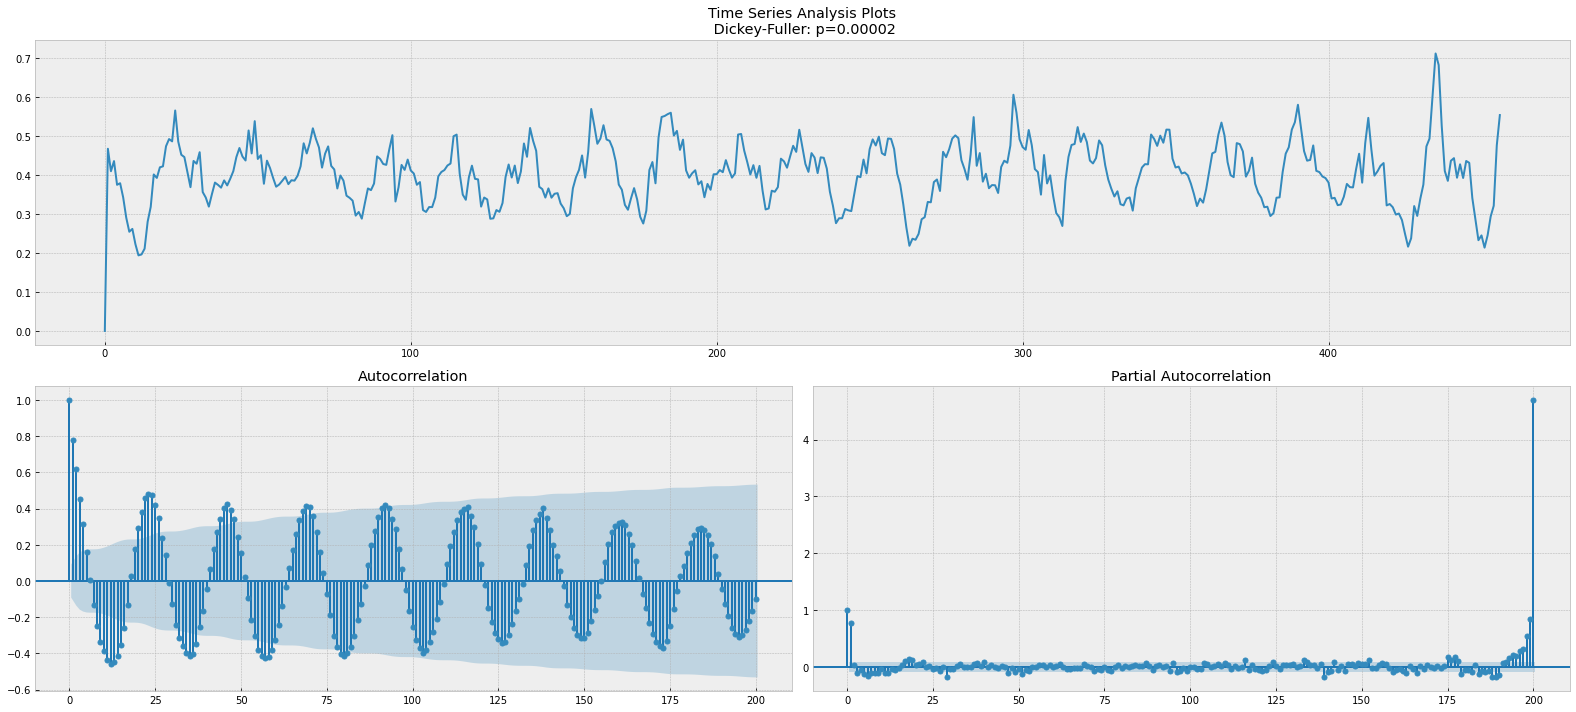

In [145]:
tsplot(SARIMA.fittedvalues, lags=200)

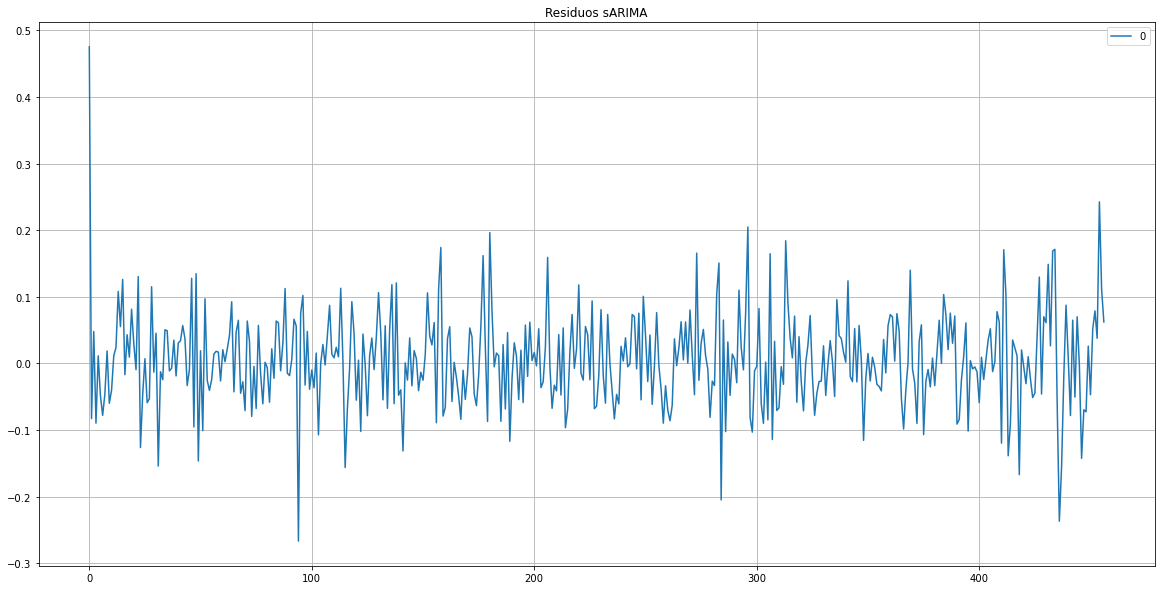

In [147]:
residuals_SARIMA = pd.DataFrame(SARIMA.resid)
residuals_SARIMA.plot(figsize = (20,10))
plt.title('Residuos sARIMA')
plt.grid()
plt.show()

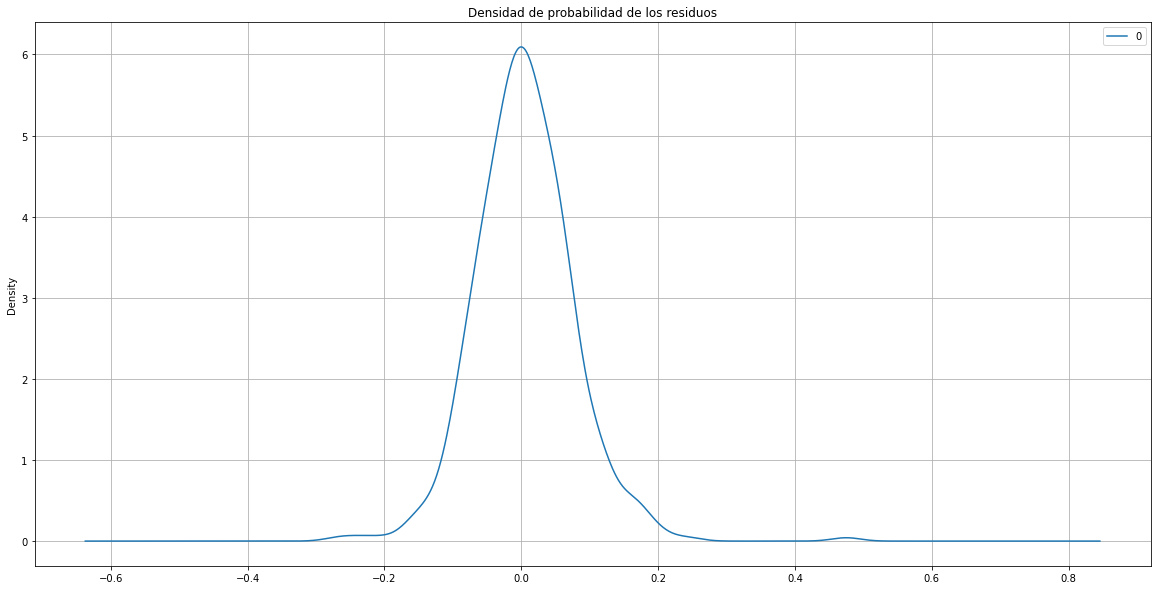

In [148]:
# density plot of residuals
residuals_SARIMA.plot(kind='kde',figsize = (20,10))
plt.title("Densidad de probabilidad de los residuos")
plt.grid()
plt.show()

# CONCLUSIONES MODELOS ARIMA Y SARIMA

## Punto 4:
* Predicciones:
    - Realizar predicciones usando (S)ARIMA
    - Realizar predicciones usando redes neuronales LSTM
    - Extraer conclusiones

### Predicciones con ARIMA

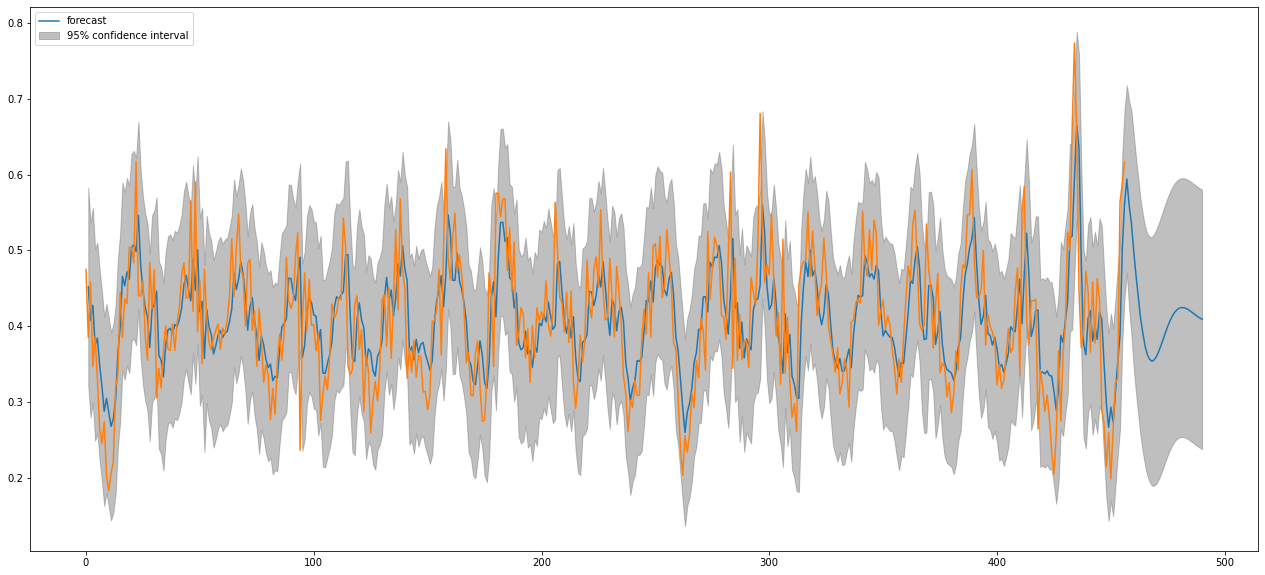

In [165]:
fig, ax = plt.subplots(figsize=(22, 10))
fig = plot_predict(arima_fit, start=1,end=490, ax=ax)
plt.plot(fid_14880['evi'].values)
legend = ax.legend(loc="upper left")
plt.show()

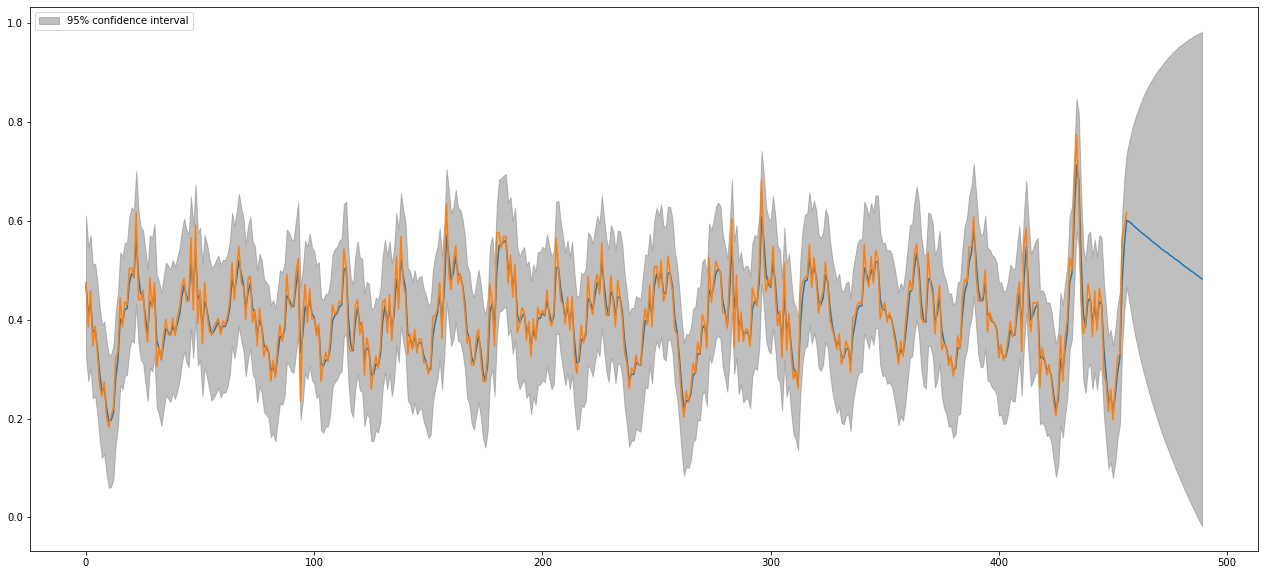

In [150]:
fig, ax = plt.subplots(figsize=(22, 10))
fig = plot_predict(SARIMA, start=1,end=490, ax=ax)
plt.plot(fid_14880['evi'].values)
legend = ax.legend(loc="upper left")
plt.show()

### LSTM

In [208]:
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

In [240]:
def sequence(tsa, n_steps):
    x, y = list(), list()
    
    for i in range(len(tsa)):
        # find the end of this pattern
        step = i + n_steps
        
        # check if we are beyond the sequence
        if step > len(tsa)-1:
            break
        
        x.append(tsa[i: step])
        y.append(tsa[step])
    
    return np.array(x), np.array(y)

In [241]:
n_steps = 5

In [242]:
x_train, y_train = sequence(fid_14880['evi'].values[:int(fid_14880['evi'].shape[0]*0.8)], n_steps)
x_test, y_test = sequence(fid_14880['evi'].values[int(fid_14880['evi'].shape[0]*0.8):], n_steps)

In [246]:
x_train.shape

(360, 5)

In [247]:
x_test.shape

(87, 5)

In [248]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))

In [249]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(n_steps,1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 5, 64)             16896     
_________________________________________________________________
lstm_42 (LSTM)               (None, 5, 128)            98816     
_________________________________________________________________
lstm_43 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 247,425
Trainable params: 247,425
Non-trainable params: 0
_________________________________________________________________


In [250]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [251]:
hist = model.fit(x_train, y_train, 
                epochs=100, 
                batch_size=16, 
                validation_split=0.1) 

Epoch 1/100
21/21 [==============================] - 1s 60ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/100
21/21 [==============================] - 0s 17ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 7/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 0.

21/21 [==============================] - 0s 10ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 63/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 64/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 65/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 66/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 67/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 68/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 69/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0040 

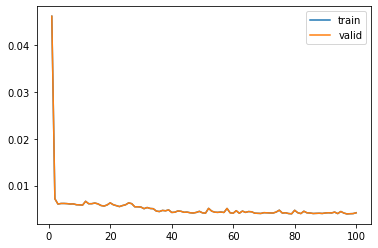

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['mse']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['mse'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['mse'], label='valid')
plt.show()

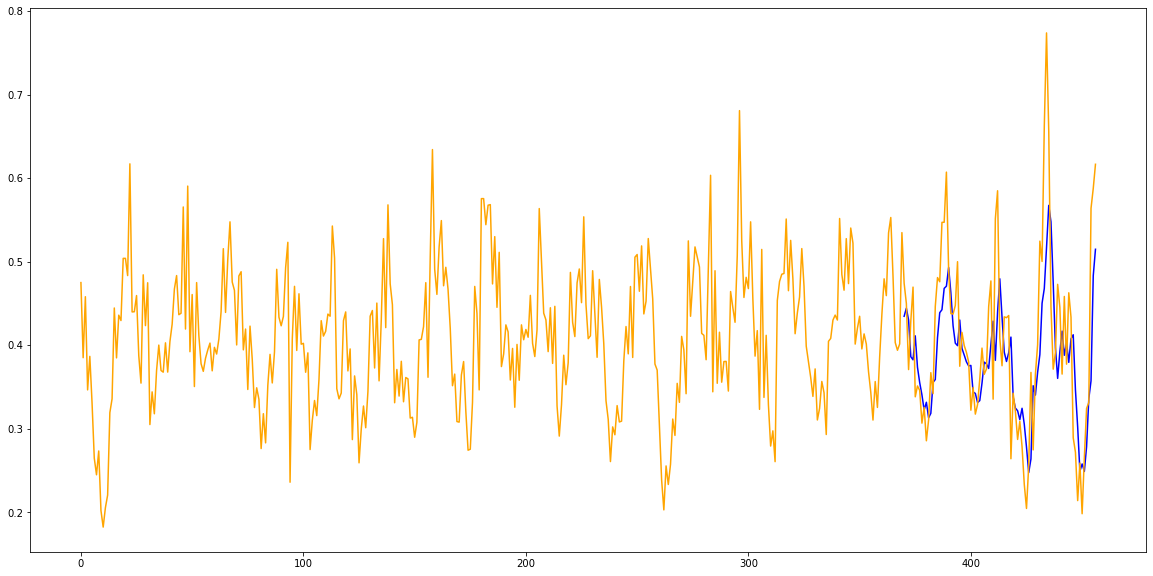

In [259]:
prediction = model.predict(x_test)
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(list(range(fid_14880['evi'].values.shape[0]-prediction.shape[0],
             fid_14880['evi'].values.shape[0],1)),prediction, color = 'blue')
ax.plot(fid_14880['evi'].values, color = 'orange')

In [ ]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values,fid_14880.evi.values, color = 'blue')
ax.plot(fid_14880['date'].values,SARIMA.fittedvalues, color = 'orange')
ax.set_title("Modelo SARIMA(3,0,1)x(1,0,1,28)")
ax.set_xlabel("Date")
ax.set_ylabel("EVI")
ax.legend(['EVI_estacional', 'SARIMA(3,0,1)x(1,0,1,28)'])
ax.grid(True)
plt.show()

In [256]:
prediction.shape

(87, 1)

In [237]:
expected_values.index = index

(360, 5, 1)

In [236]:
x_train.shape

(360, 5, 1)

#### Calculo componente estacional e implementacion de ARIMA

### Modelo Aditivo ARIMA

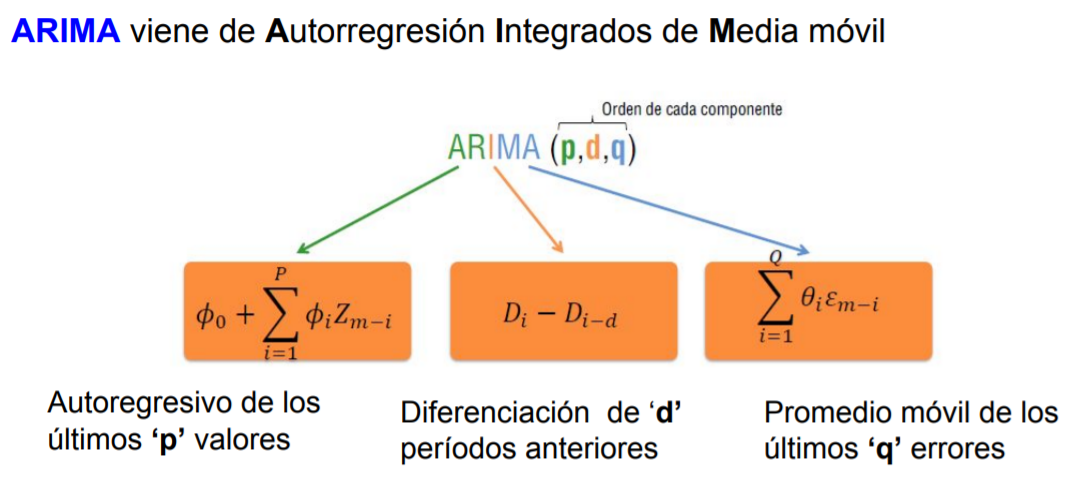

El orden del parametro AR (p) lo estableceremos en funcion de la autocorrelacion parcial, y el orden del parametro MA (q) lo elegiremos a partir de la autocorrelacion. Por lo tanto se popone:
   * p = 3
   * q = 2

In [ ]:
residuals = pd.DataFrame(model_fit_2.resid)
residuals.plot(figsize = (20,10))
plt.title('Residuos ARIMA')
plt.grid()
plt.show()

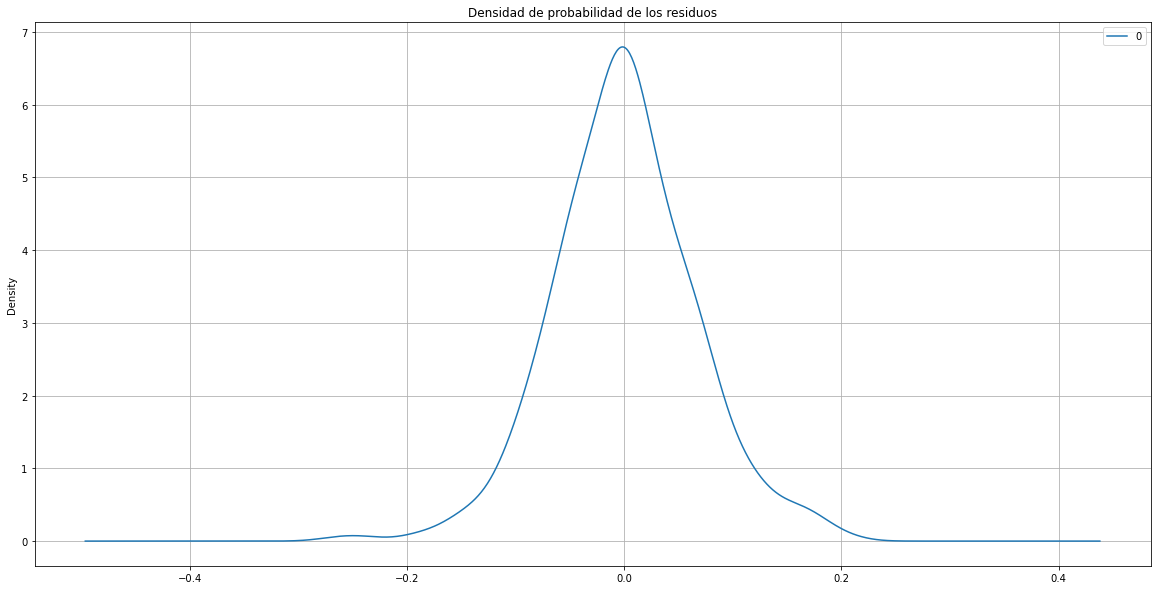

In [67]:
# density plot of residuals
residuals.plot(kind='kde',figsize = (20,10))
plt.title("Densidad de probabilidad de los residuos")
plt.grid()
plt.show()

In [68]:
# summary stats of residuals
print(residuals.describe())

                0
count  457.000000
mean     0.000022
std      0.065620
min     -0.262709
25%     -0.040842
50%     -0.001615
75%      0.038036
max      0.204360


C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\tsa\stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


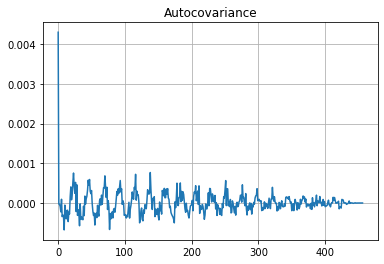

In [69]:
# Autocovarianza
#C_k del residuo
plt.plot(acovf(residuals))
plt.grid(True)
plt.title("Autocovariance")
plt.show()

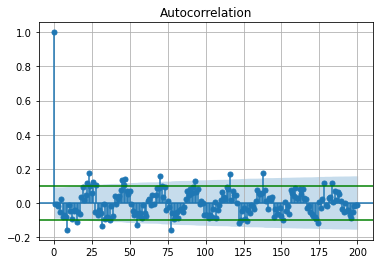

In [70]:
# Autocorrelacion
# R_k
plot_acf(residuals, lags=200)
plt.grid(True)
plt.axhline(y=0.1, color='green')
plt.axhline(y=-0.1, color='green')
plt.show()

### Modelo Multiplicativo: SARIMA

SARIMA(p,d,q)x(P,D,Q)s, con período estacional s


In [259]:
SARIMA = sm.tsa.statespace.SARIMAX(fid_14880.evi.values, order=(3, 1, 0), seasonal_order=(2, 1, 1, 20)).fit(disp=-1)

In [260]:
print(SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  457
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 20)   Log Likelihood                 517.015
Date:                              Wed, 15 Dec 2021   AIC                          -1020.029
Time:                                      19:29:31   BIC                           -991.486
Sample:                                           0   HQIC                         -1008.765
                                              - 457                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3548      0.042     -8.395      0.000      -0.438      -0.272
ar.L2         -0.12

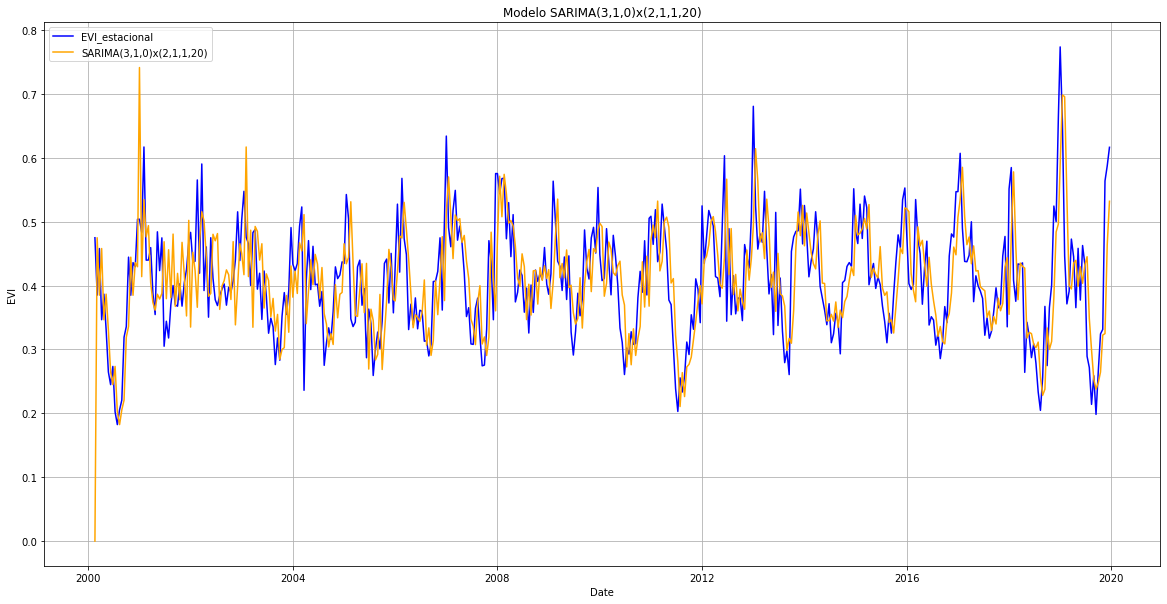

In [264]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values,fid_14880.evi.values, color = 'blue')
ax.plot(fid_14880['date'].values,SARIMA.fittedvalues, color = 'orange')
ax.set_title("Modelo SARIMA(3,1,0)x(2,1,1,20)")
ax.set_xlabel("Date")
ax.set_ylabel("EVI")
ax.legend(['EVI_estacional', 'SARIMA(3,1,0)x(2,1,1,20)'])
ax.grid(True)
plt.show()

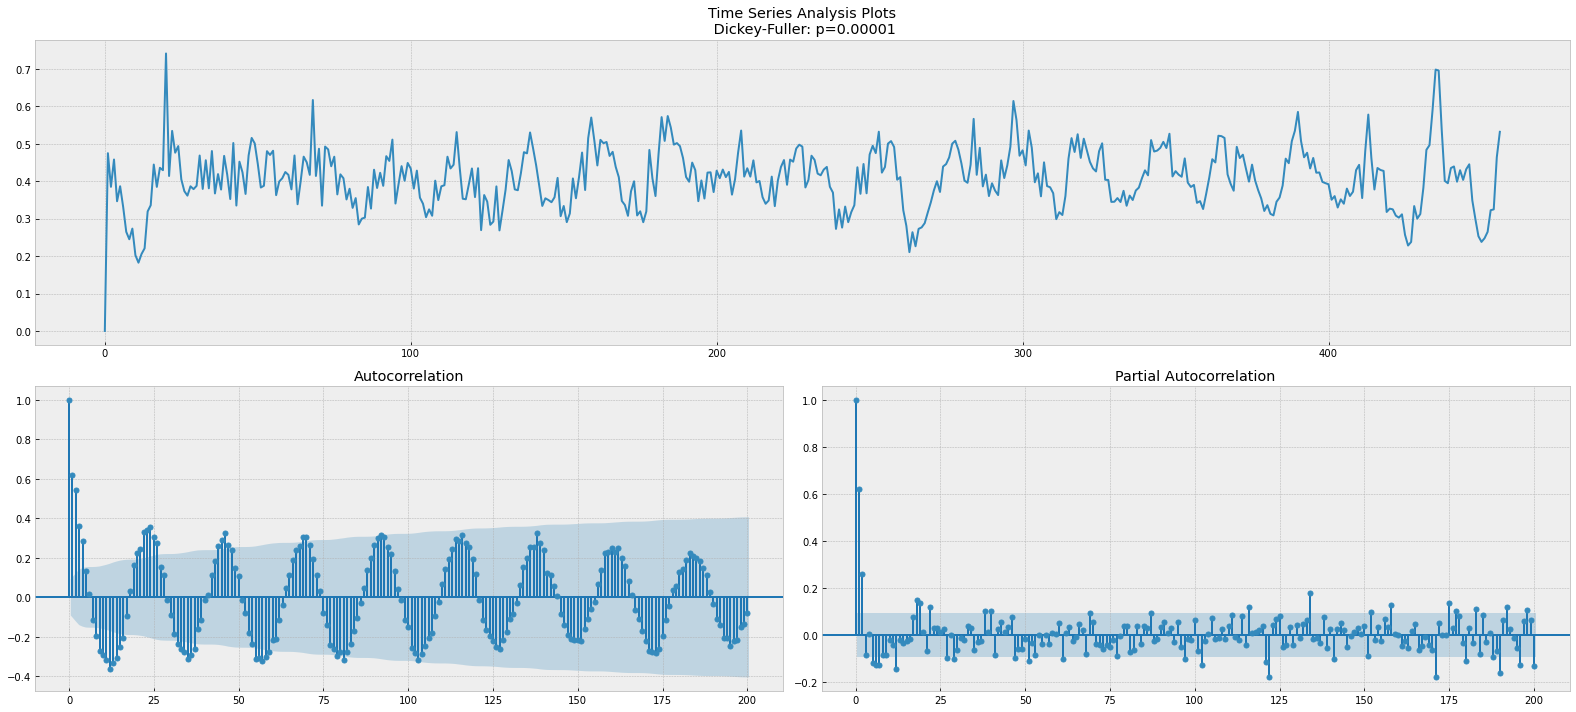

In [261]:
tsplot(SARIMA.fittedvalues, lags=200)

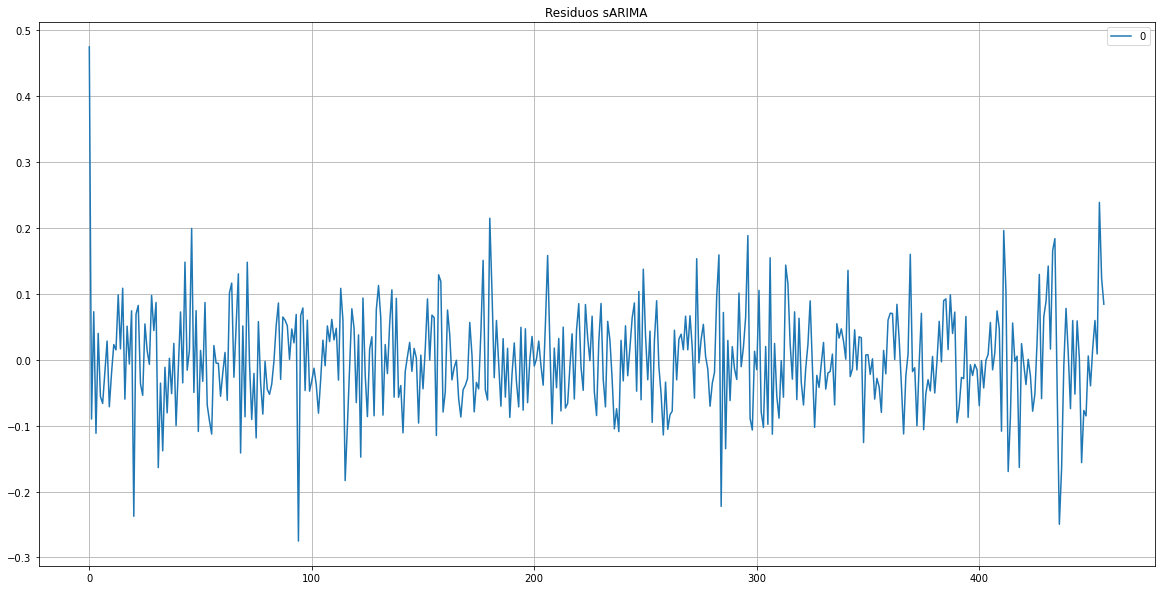

In [287]:
residuals_SARIMA = pd.DataFrame(SARIMA.resid)
residuals_SARIMA.plot(figsize = (20,10))
plt.title('Residuos sARIMA')
plt.grid()
plt.show()

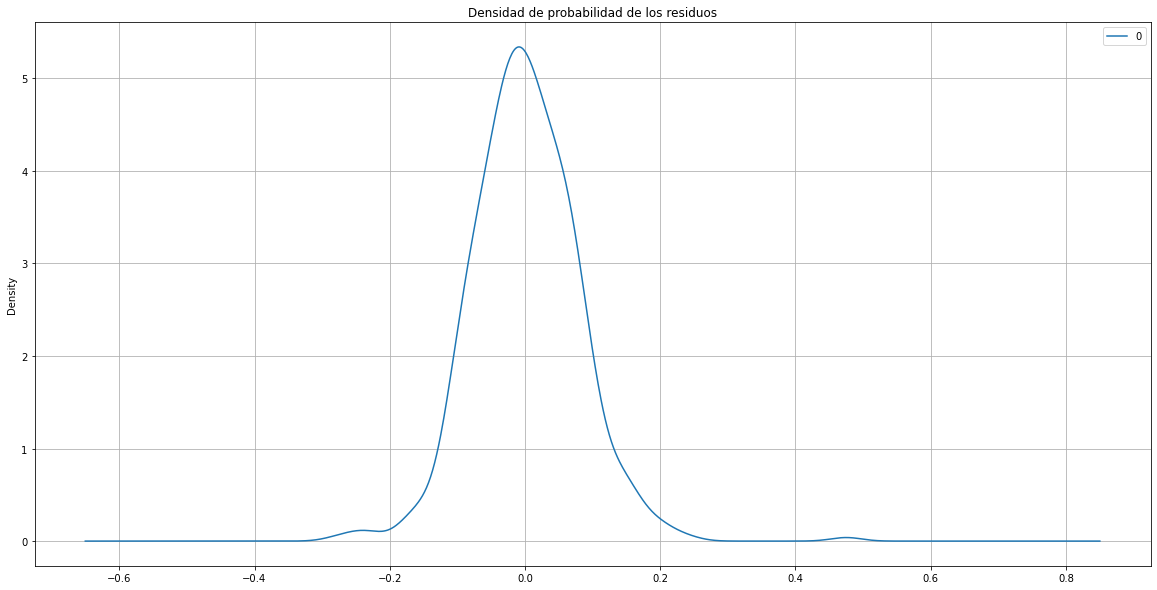

In [288]:
# density plot of residuals
residuals_SARIMA.plot(kind='kde',figsize = (20,10))
plt.title("Densidad de probabilidad de los residuos")
plt.grid()
plt.show()